In [1]:
import torch 
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.datasets as datasets
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
%load_ext tensorboard

In [2]:
from torch.utils.tensorboard import SummaryWriter

In [3]:
# Class Discriminator 
class Discrimintator(nn.Module):
    def __init__(self,img_dim):
        super().__init__()
        self.disc = nn.Sequential(nn.Linear(img_dim,128),nn.LeakyReLU(0.1),nn.Linear(128,1),nn.Sigmoid(),)
        # we are creating a neural netwrok with features supplied to 128 neuron and the leakyrelu
        # BY setting the leaky relu as 1 all the negative slopes will be multiplied by 0.1 
        # In the end we need only one output from the neural network and lastly we use sigmoid, to scale the output between 
        # 0 ad 1.
        
    def forward(self,x):
        return self.disc(x)
    
class Generator(nn.Module):
    # here the z dimesion is the latent noise that we will add as discussed while explaining the theory of the Gan's
    def __init__(self,z_dim,img_dim):
        # and we are also suppling the original dimesions too......
        # image dimension would be around 784 as we are using the mnist dataset 
        super().__init__()
        self.gen = nn.Sequential(
        nn.Linear(z_dim,256),nn.LeakyReLU(0.1),nn.Linear(256,img_dim),nn.Tanh(),)
        # tanh activation function will give us the value between -1 and 1, 
        # we need the output to be in -1 to 1 as we are going to normalize the inputs from the mnist dataset
    def forward(self,x):
        return self.gen(x)
        
# Hyperparametrs......
# Gans are very sensitive to hyperparametrs

In [4]:
# Hyperparametrs definations, based of the given papers............ 
device ="cuda" if torch.cuda.is_available() else "cpu"
lr= 3e-4 # this learning rate was given, but we can change and check some more lr around
z_dim = 64 # we can have other dims to like 128, 256 etc 
image_dim= 28*28*1# 784
batch_size=32
num_epochs =50
disc = Discrimintator(image_dim).to(device)
gen =Generator(z_dim,image_dim)
fixed_noise = torch.randn((batch_size,z_dim)).to(device)
# the reason we are giving fixed noise so that we can see how it has changed across the epochs 
transforms = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])
# in the normalize we are using 0.1307 and 0.3081 as mean and standard deviation of the dataset.. as this is the actual
# mean and deviation of the mnsit dataset. but we are using 0.5 for both as we are not able to converge our model.
dataset= datasets.MNIST(root='dataset/', transform = transforms,download = True)
loader=DataLoader(dataset,batch_size=batch_size, shuffle=True)# loading the dataset and shuffling the obtained dataset 
opt_disc=optim.Adam(disc.parameters(),lr=lr)
# optimizer for for discriminatort
opt_gen=optim.Adam(gen.parameters(),lr=lr)
criterion = nn.BCELoss()# its the binary cross entropy loss that we are using itys similar to the loss function that is given in
# the paper for Gans
writer_fake=SummaryWriter(f"runs/GAN_MNIST/fake")
writer_real=SummaryWriter(f"runs/GAN_MNIST/real")
step =0

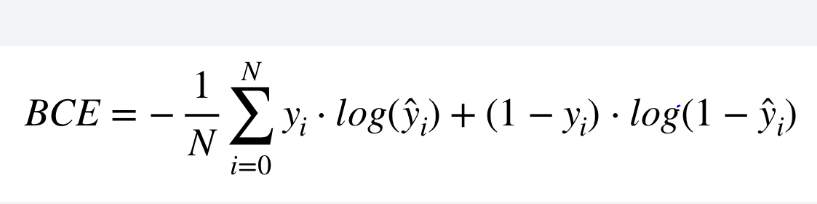

In [ ]:
# calculations for discriminator loss
for epoch in range(num_epochs):
    for batch_idx, (real, _) in enumerate(loader):
        real =real.view(-1,784).to(device)
        # so in the above we want to keep the samples in our batch therefore -1 and then we flatten everything to be 784
        batch_size = real.shape[0] # to get the first dimension
        # so the discrimiator needs to maximize its loss
        # therefore trainig discriminator be like: max log(d(real)) + log(1-D(G(z))), to maximize this loss function for discriminator
        noise = torch.randn(batch_size, z_dim).to(device)# , random normal distribution based numbers ,means:- mean=0 and std=1
        fake= gen(noise)
        disc_real = disc(real).view(-1) # to flatten  everything
        # generating some fake images 
        lossD_real = criterion(disc_real,torch.ones_like(disc_real))   

# As we are using the binary cross entropy loss, there fore we need to pass yi as 1's as to get the same output
# for logyi, where as the second term would be 0 if we look at the above loss function, but in the bce we have -1/n, which we can convert to 
# 1 but for the negative part we now need to minimize this function as it will then act the same way.
# given the code we have the max log(d(real)) as of now but we have the - sign ahead there fore now we need to minimize 
# the given function.
# now we are going to calculate the second part of our loss that is log(1-D(G(z))) where we already have fake variable as 
# d(g(z)) and 

        disc_fake = disc(fake).view(-1)
        lossD_fake = criterion(disc_fake, torch.zeros_like(disc_fake))

# Now back to the loss function of BCE, where we are giving the argument zeroes because we want to amke the 1-yi as 1.
# so that we can obtain log(1-d(g(z))), using the BCE, here the same negative probem arisies but we can now just minimzie the
# expression instead of maximizing the expression.
        
        lossD = (lossD_real + lossD_fake)/ 2
        disc.zero_grad()
        lossD.backward(retain_graph = True)# this will help us retian the intermediate calculations that we performed,
        # to get the loss for discriminator
        opt_disc.step()
        
# Now we have to train the generator and we have to minimize the log(1-D(G(z))).............., this function leads to saturation
# of gradients therefore we instead of minimizing this expression we will maximize the max log(D(G(z))), expression, so as to 
# avoid the vanishing gradient problem that may occur while traing the neural netwrok....
        output = disc(fake).view(-1)# to compute the actual gradients we are going to need the intermediate results from this 
# fake and thats only still there in the computationla grpah as we retain the graph
        lossG = criterion(output,torch.ones_like(output))
# calculating again from the BCE as we there already exist a negative sign in the equation we now have to maximize our 
# loss instead of minimizing our losss........
        gen.zero_grad()
        lossG.backward()
        opt_disc.step()
        # Some additional code for tensorboard that help us visualize the data 
        if batch_idx == 0:
            print(f"Epoch [{epoch}/{num_epochs}] \ "
            f"Loss D: {lossD:.4f},Loss G:{lossG:.4f}"
            )
            
            with torch.no_grad():
                fake = gen(fixed_noise).reshape(-1,1,28,28)
                data =real.reshape(-1,1,28,28)
                img_grid_fake = torchvision.utils.make_grid(fake,normalize=True)
                img_grid_real = torchvision.utils.make_grid(data,normalize=True)
                writer_fake.add_image("Mnist Fake Images",img_grid_fake,global_step = step)
                writer_real.add_image("Mnist Real Images",img_grid_real,global_step = step)
                step +=1
# it will take an eternity to run on cpu and the losses obtained are not changing much 

Epoch [0/50] \ Loss D: 0.7327,Loss G:0.7195
Epoch [1/50] \ Loss D: 0.3465,Loss G:0.6938
Epoch [2/50] \ Loss D: 0.3468,Loss G:0.6930
Epoch [3/50] \ Loss D: 0.3466,Loss G:0.6935
Epoch [4/50] \ Loss D: 0.3464,Loss G:0.6940
Epoch [5/50] \ Loss D: 0.3467,Loss G:0.6932
Epoch [6/50] \ Loss D: 0.3467,Loss G:0.6931
Epoch [7/50] \ Loss D: 0.3466,Loss G:0.6933
Epoch [8/50] \ Loss D: 0.3464,Loss G:0.6936
Epoch [9/50] \ Loss D: 0.3466,Loss G:0.6933
Epoch [10/50] \ Loss D: 0.3463,Loss G:0.6938
Epoch [11/50] \ Loss D: 0.3466,Loss G:0.6933
Epoch [12/50] \ Loss D: 0.3465,Loss G:0.6933
Epoch [13/50] \ Loss D: 0.3462,Loss G:0.6940
Epoch [14/50] \ Loss D: 0.3464,Loss G:0.6935
Epoch [15/50] \ Loss D: 0.3464,Loss G:0.6937
Epoch [16/50] \ Loss D: 0.3467,Loss G:0.6931
Epoch [17/50] \ Loss D: 0.3462,Loss G:0.6939
Epoch [18/50] \ Loss D: 0.3464,Loss G:0.6936
Epoch [19/50] \ Loss D: 0.3466,Loss G:0.6932
Epoch [20/50] \ Loss D: 0.3464,Loss G:0.6936
Epoch [21/50] \ Loss D: 0.3466,Loss G:0.6932
Epoch [22/50] \ Loss

In [ ]:
# Originally we have to maximize the discriminator loss and minimze the generator loss, but we are doing it differently because 
# we had to tune the BCE and then gather the parameters 

# things that we can try to improve:
#1. Larger netwrok other than linear
# 2. Better Normalization with batch norm
# 3. changing and tuning hyper parameters 
# 4. change architecture to CNN 
